_Lambda School Data Science, Unit 2_

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders`.

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders

 
# Sprint Challenge: Predict Steph Curry's Shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts from October 2009 through June 2019 (regular season and playoffs). The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

You'll create a model to predict whether Curry will make a shot based on his past perfomance.

# Directions

This notebook contains 10 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Feature engineering.
- **Task 3:** Splitting data into a feature matrix and target vector.
- **Task 4:** Splitting data into training, validation, and test sets.
- **Task 5:** Establishing baseline accuracy.
- **Task 6:** Building a model with a transformer and a tree-based predictor.
- **Task 7:** Calculating training and validation accuracy.
- **Task 8 (`stretch goal`):** Tuning model hyperparameters.
- **Task 9:** Calculating precision and recall from a confusion matrix.
- **Task 10 (`stretch goal`):** Plotting a confusion matrix.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise 
NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `sklearn`



# I. Wrangle Data

# **Task 1:**
Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set at the index.

In [2]:
'''T1. Import DataFrame `df`'''

import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, classification_report, plot_confusion_matrix

url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url)
# YOUR CODE HERE
# raise NotImplementedError()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
type(df.index)
df

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13953,41800403,570,Stephen Curry,4,8,1,Pullup Jump shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,12,3,120,1,2019-06-05,GSW,TOR,Playoffs,-13.0
13954,41800403,573,Stephen Curry,4,7,16,Floating Jump shot,2PT Field Goal,Mid-Range,Right Side(R),8-16 ft.,11,114,-5,0,2019-06-05,GSW,TOR,Playoffs,-14.0
13955,41800403,602,Stephen Curry,4,5,27,Step Back Jump shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,26,-217,149,0,2019-06-05,GSW,TOR,Playoffs,-17.0
13956,41800403,608,Stephen Curry,4,4,50,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,7,59,49,0,2019-06-05,GSW,TOR,Playoffs,-16.0


In [4]:
# formatting the data correctly so that it is a datetime object
df['game_date'] = pd.to_datetime(df['game_date'], infer_datetime_format=True, yearfirst=True)

# setting game data as index now
df.set_index(df['game_date'], inplace=True)
df.info()
df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13958 entries, 2009-10-28 to 2019-06-05
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   game_id                  13958 non-null  int64         
 1   game_event_id            13958 non-null  int64         
 2   player_name              13958 non-null  object        
 3   period                   13958 non-null  int64         
 4   minutes_remaining        13958 non-null  int64         
 5   seconds_remaining        13958 non-null  int64         
 6   action_type              13958 non-null  object        
 7   shot_type                13958 non-null  object        
 8   shot_zone_basic          13958 non-null  object        
 9   shot_zone_area           13958 non-null  object        
 10  shot_zone_range          13958 non-null  object        
 11  shot_distance            13958 non-null  int64         
 12  loc_x          

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
game_date,,,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0
2009-10-28,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0
2009-10-28,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0
2009-10-28,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0
2009-10-28,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-05,41800403,570,Stephen Curry,4,8,1,Pullup Jump shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,12,3,120,1,2019-06-05,GSW,TOR,Playoffs,-13.0
2019-06-05,41800403,573,Stephen Curry,4,7,16,Floating Jump shot,2PT Field Goal,Mid-Range,Right Side(R),8-16 ft.,11,114,-5,0,2019-06-05,GSW,TOR,Playoffs,-14.0
2019-06-05,41800403,602,Stephen Curry,4,5,27,Step Back Jump shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,26,-217,149,0,2019-06-05,GSW,TOR,Playoffs,-17.0


**Task 1 Testing**

In [5]:
'''T1 Testing'''

assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 13958, 'Is `df` the correct length?'


**Task 2a:** Engineer at least 1 new feature. You can use something from the list below or your own idea.

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**Task 2b (`stretch goal — optional`):** Create a total of 3 new features, using your own ideas or the list above. Make sure you're not just duplicating features that are already in the feature matrix.

# Task 2.
Create new feature

In [6]:
#finding the shape of the existing dataframe
df.shape

(13958, 20)

In [7]:
"""T2. Create new feature"""
# making total_seconds_remaining in period
df['total_seconds_remaining_period'] = df['minutes_remaining'] * 60 + df['seconds_remaining']

#making total seconds remaining in game
df['total_seconds_remaining'] = (4 - df['period']) * 12 * 60  + df['minutes_remaining'] * 60 + df['seconds_remaining']

# dropping game_date from the features
df.drop(columns = 'game_date', inplace=True)
df.shape
# raise NotImplementedError()

(13958, 21)

**Task 2 Test**

In [8]:
'''T2 Testing'''

assert df.shape[1] >= 20, '`df` does not appear to have new features.'


# II. Split Data

# **Task 3:**
Divide the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'shot_made_flag'`.

In [9]:
'''T3. Create `X` and `y`.'''
target = 'shot_made_flag'
X = df.drop(columns= target)
y = df[target]
# raise NotImplementedError()
print (X.shape, y.shape)

(13958, 20) (13958,)


**Task 3 Test**

In [10]:
'''T3 Tests'''

assert y.shape == (13958,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 13958, '`X` has the wrong number of rows.'
assert X.shape[1] > 1, '`X` has the wrong number of columns'
assert 'shot_made_flag' not in X.columns, 'Target is still part of feature matrix.' 

# **Task 4:**
Divide your dataset into training, validation, and test sets.

- Your training set (`X_train`, `y_train`) should contain games from the 2009-10 season through the end of the 2016-17 season.
- Your validation set (`X_val`, `y_val`) should contain games from the 2017-18 season.
- Your test set (`X_test`, `y_test`) should contain games from the 2018-2019 season.
- **Tip:** The NBA season begins in October and ends in June.

In [11]:
'''T4. Create training and val'''
#training set
train_condition = X.index < '2017-10-01'
X_train = X[train_condition]
y_train = y[train_condition]

#validation set
val_condition = (X.index > '2017-09-30') & (X.index < '2018-10-01')
X_val = X[val_condition]
y_val = y[val_condition]

#test set
test_condition = X.index > '2018-09-30'
X_test = X[test_condition]
y_test = y[test_condition]

# print all the shapes
print (X_train.shape, y_train.shape)
print (X_val.shape, y_val.shape)
print (X_test.shape, y_test.shape)

# raise NotImplementedError()

(11081, 20) (11081,)
(1168, 20) (1168,)
(1709, 20) (1709,)


**Test 4**

In [12]:
'''T4 Tests'''
assert len(X_train) == len(y_train) == 11081
assert len(X_val) == len(y_val) == 1168
assert len(X_test) == len(y_test) == 1709


# III. Establish Baseline

# **Task 5:**
## Parvi - This is a classification problem as we are trying to predict for 0 and 1.
Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [13]:
'''T5. Calculate baseline accuracy `baseline_acc`.'''
# This is a classification problem
# finding the maximum number of values in the target to be our baseline
print(y_train.value_counts(normalize=True))

# baseline accuracy for a no goal
baseline_acc = 0.527209
print()
# raise NotImplementedError()
print('Baseline Accuracy:', baseline_acc)

0    0.527209
1    0.472791
Name: shot_made_flag, dtype: float64

Baseline Accuracy: 0.527209


**Task 5 Testing**

In [14]:
'''T5 Testing'''

assert isinstance(baseline_acc, float)
assert 0.0 <= baseline_acc <= 1.0


# IV. Build Model

# **Task 6:**
Build a model that includes (1) a transformer for categorical features and (2) a tree-based predictor. You should combine these two components (and any other pieces you think are necessary) in a pipeline named `model`. Be sure to fit your model to your training data.

In [15]:
# Pandas profiling didn't work follow up later with instructor.
# from pandas_profiling import ProfileReport
# report = ProfileReport(df, minimal=True).to_notebook_iframe()
# report

In [16]:
# make sure all the features in the X_train are having a resonable cardinality
X_train.describe(include='all')

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,htm,vtm,season_type,scoremargin_before_shot,total_seconds_remaining_period,total_seconds_remaining
count,1.108100e+04,11081.000000,11081,11081.000000,11081.000000,11081.000000,11081,11081,11081,11081,11081,11081.000000,11081.000000,11081.000000,11081,11081,11081,11081.000000,11081.000000,11081.000000
unique,NaN,NaN,1,NaN,NaN,NaN,51,2,7,6,5,NaN,NaN,NaN,32,32,2,NaN,NaN,NaN
top,NaN,NaN,Stephen Curry,NaN,NaN,NaN,Jump Shot,2PT Field Goal,Above the Break 3,Center(C),24+ ft.,NaN,NaN,NaN,GSW,GSW,Regular Season,NaN,NaN,NaN
freq,NaN,NaN,11081,NaN,NaN,NaN,5375,5941,4298,4820,5065,NaN,NaN,NaN,5512,5569,9642,NaN,NaN,NaN
mean,2.390649e+07,256.660951,NaN,2.423518,4.765454,28.512770,NaN,NaN,NaN,NaN,NaN,17.290046,0.081130,128.766537,NaN,NaN,NaN,1.427940,314.440032,1449.507265
std,6.772101e+06,160.407276,NaN,1.131651,3.334664,17.572019,NaN,NaN,NaN,NaN,NaN,10.187723,123.088631,101.338212,NaN,NaN,NaN,10.203112,201.623809,855.525081
min,2.090002e+07,2.000000,NaN,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,-250.000000,-41.000000,NaN,NaN,NaN,-39.000000,0.000000,-1432.000000
25%,2.120027e+07,102.000000,NaN,1.000000,2.000000,13.000000,NaN,NaN,NaN,NaN,NaN,8.000000,-92.000000,23.000000,NaN,NaN,NaN,-5.000000,143.000000,812.000000
50%,2.140028e+07,263.000000,NaN,2.000000,5.000000,29.000000,NaN,NaN,NaN,NaN,NaN,21.000000,1.000000,138.000000,NaN,NaN,NaN,1.000000,300.000000,1440.000000
75%,2.160010e+07,377.000000,NaN,3.000000,7.000000,43.000000,NaN,NaN,NaN,NaN,NaN,25.000000,94.000000,214.000000,NaN,NaN,NaN,8.000000,479.000000,2272.000000


In [17]:
'''T6. Build a pipeline `model` with encoder and tree-based predictor.'''


#instantiating the pipeline with OHE and RandomForestClassifier
model = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestClassifier()
)

model.fit(X_train, y_train)
# raise NotImplementedError()

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['player_name', 'action_type', 'shot_type',
                                      'shot_zone_basic', 'shot_zone_area',
                                      'shot_zone_range', 'htm', 'vtm',
                                      'season_type'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'player_name',
                                          'data_type': dtype('O'),
                                          'mapping': Stephen Curry    1
NaN             -2
dtype: int64},
                                         {'...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                   

**Task 6 Testing**

In [18]:
'''T6 Testing'''

from sklearn.pipeline import Pipeline
assert isinstance(model, Pipeline), '`model` should be type `Pipeline`.'

# Does `model` Pipeline have multiple components?
assert len(model.named_steps.keys()) > 1, '`model` should have more than one component.'

# Has `model` been trained?
assert hasattr(model, 'classes_'), 'Have you trained `model`?'


# V. Check Metrics

**Task 7:** Check the training and validation accuracy of your model, and assign the scores to `train_acc` and `val_acc` respectively.


In [19]:
'''T7. Calculate train and test accuracy.'''

# YOUR CODE HERE
train_acc = model.score(X_train, y_train)
val_acc = model.score(X_val, y_val)

# raise NotImplementedError()
print('Training Accuracy Score:', train_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 1.0
Validation Accuracy Score: 0.5950342465753424


**Task 7 Test**

In [20]:
'''T7 Testing'''

# Is `training_acc` a float between 0.0 and 1.0?
assert isinstance(train_acc, float)
assert 0.0 <= train_acc <= 1.0

# Is `validation_acc` a float between 0.0 and 1.0?
assert isinstance(val_acc, float)
assert 0.0 <= val_acc <= 1.0


# VI. Tune Model

**Task 8 (`stretch goal — optional`):** Using your training and validation sets as a guide, tune the hyperparameters of your model to see if you can improve its accuracy. You can perform your tuning "by hand" or using [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

- Important hyperparameters for all tree-based models: `max_depth`.
- Important hyperparameters for random forest models: `n_estimators`, `max_samples`. 
- Important hyperparametes for gradient boosting tree models: `n_estimators`, `learning_rate`.
- **TIP:** If you use `RandomizedSearchCV`, set `n_iter` to `3`. Any larger and the auto-grader will stop working.
- **TIP:** Since you already created a validation set above, there is no need to do k-fold cross-validation here. Set `cv` to `None`.

Once you're satisfied with your model's performance on the validation set (if you can get above `0.6`, you're doing good), calculate its accuracy with your test set. Assign the result to `test_acc`.

In [21]:
'''T8. Tune model.'''


# UNCOMMENT THE SECTION BELOW, COMMENTING ELSE AUTOGRADER WILL CRASH
# declaring the parameters distribution for RandomizedSearchCV
# params_distibutions = {
#     'randomforestclassifier__max_depth': [range(5,100,10), None],
#     'randomforestclassifier__n_estimators': range(100,1000,100),
#     'randomforestclassifier__max_samples': np.arange(0.2,0.8,0.2)
#
# }
#
# # instantiate the RandomizedSearchCV object
# model_cv = RandomizedSearchCV(
#     model,
#     param_distributions=params_distibutions,
#     n_iter=10,
#     n_jobs=-1,
#     verbose=1,
#     random_state=42,
#     return_train_score=True,
#     cv=None
# )

params_distibutions = {
    'randomforestclassifier__max_depth': [range(5,100,10), None],
    'randomforestclassifier__n_estimators': range(100,1000,100),
    'randomforestclassifier__max_samples': np.arange(0.2,0.8,0.2)

}

# instantiate the RandomizedSearchCV object
model_cv = RandomizedSearchCV(
    model,
    param_distributions=params_distibutions,
    n_iter=2,
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True,
    cv=None
)

# best parameters
'''
{'randomforestclassifier__n_estimators': 600,
 'randomforestclassifier__max_samples': 0.4,
 'randomforestclassifier__max_depth': None}'''

#update model with the best hyperparameters

model_cv = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestClassifier(n_estimators=600, max_depth=None, max_samples=0.4)
)

# fitting
model_cv.fit(X_train, y_train)
test_acc = model_cv.score(X_test, y_test)
# raise NotImplementedError()
print('Testing Accuracy Score:', test_acc)

Testing Accuracy Score: 0.6342890579286132


**Task 8 Testing**

In [22]:
'''T8 Testing'''
assert isinstance(test_acc, float)
assert 0.0 <= test_acc <= 1.0

# VII. Communication

# **Task 9:**
Below is a confusion matrix for the model that your instructor made for this challenge (based on the **test data**). Calculate the precision and recall of this model, naming them `instructor_precision` and `instructor_recall`, respectively.

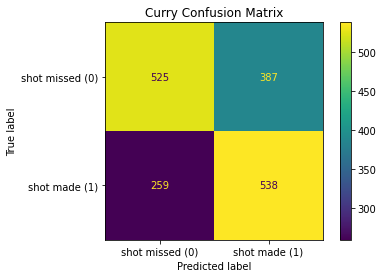

              precision    recall  f1-score   support

           0       0.66      0.65      0.65       912
           1       0.61      0.62      0.61       797

    accuracy                           0.63      1709
   macro avg       0.63      0.63      0.63      1709
weighted avg       0.63      0.63      0.63      1709

Instuctor model precision 0.6076260762607626
Instuctor model recall 0.6198243412797992


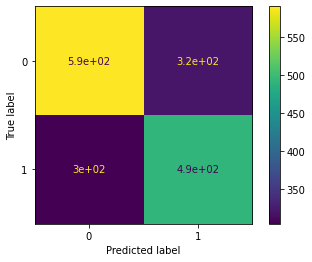

In [23]:
'''T9. Calculate precision and recall'''

plot_confusion_matrix(model_cv, X_test, y_test)

instructor_precision = 494/(494+319)
instructor_recall = 494/(494+303)

# finding the values from classification report to check the manual calculations
print(classification_report(y_test, model_cv.predict(X_test)))
# raise NotImplementedError()
print('Instuctor model precision', instructor_precision)
print('Instuctor model recall', instructor_recall)

**Task 9 Testing**

In [24]:
'''T9 Testing'''
assert isinstance(instructor_precision, float)
assert isinstance(instructor_recall, float)
assert 0 <= instructor_precision <= 1
assert 0 <= instructor_recall <= 1

**Task 10 (`stretch goal — optional`):** Plot confusion matrix for your model using your **test data**. Does your model have higher recall or higher precision? How does your model's metrics compare to the metrics you calculated above?

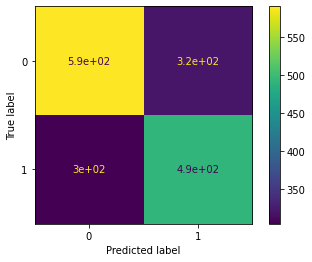

In [25]:
# plotted the confusion matrix above. Plotting again in case the autograder penalizes me for not doing it here.
plot_confusion_matrix(model_cv, X_test, y_test)
# the model has a marginally higher recall
# the metrics i calculated above at in line with the one determined by confusion matrix.

'''T10. Plot ROC curve.'''
# get the y_pred_probability first
y_pred_proba = model_cv.predict_proba(X_test)[:,1]

#get the FPR and TPR
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)
#


Text(0.5, 0, 'False Positive Rate')

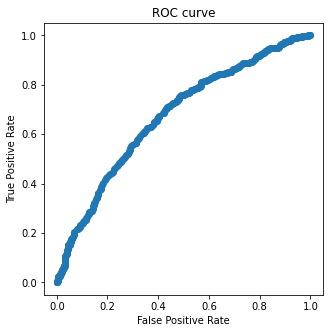

In [26]:
# #plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(fpr, tpr)
ax.set_title('ROC curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# raise NotImplementedError()